# Machine Learning Final Project: Identify Fraud from Enron Email

##### Overview:
In this project, you will play detective, and put your machine learning skills to use by building an algorithm to identify Enron Employees who may have committed fraud based on the public Enron financial and email dataset.

This project will teach you the end-to-end process of investigating data through a machine learning lens. It will teach you how to extract and identify useful features that best represent your data, a few of the most commonly used machine learning algorithms today, and how to evaluate the performance of your machine learning algorithms.

In [1]:
#!/usr/bin/python

import sys
import pickle
import matplotlib.pyplot as plt                                 
sys.path.append("../tools/")

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data
from collections import defaultdict                              

### Task 1: Select what features you'll use.
### features_list is a list of strings, each of which is a feature name.
### The first feature must be "poi".
features_list = ['poi','salary','total_stock_value','exercised_stock_options',
                 'total_payments','bonus','long_term_incentive','to_messages',
                 'from_poi_to_this_person', 'from_messages',
                 'from_this_person_to_poi','shared_receipt_with_poi']

### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)


# With Persons of Interest likely playing a significatn role in our investigation, we'll
# run summary stats on this feature group to see what we are working with in the
# provided dataset.  
poi_total = 0
for person, feature in data_dict.iteritems():
    if feature['poi']:
        poi_total +=1

print 'Number of POIs:', poi_total              


# Supplied in the zip file from Udacity was a list of Persons of Interests, containing 35 individuals, sourced from 
# USA Today article (http://usatoday30.usatoday.com/money/industries/energy/2005-12-28-enron-participants_x.htm). 
# We identify a discrepency between the what was provided in the source file and the final_project_dataset.pkl file.
# Is the dataset a better indicator of POI?
with open("poi_names.txt") as f:
    poi_list_usat = len(f.readlines()[2:])
print 'Number of POIs from USA Today:', (poi_list_usat) 

Number of POIs: 18
Number of POIs from USA Today: 35


/Users/craig/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


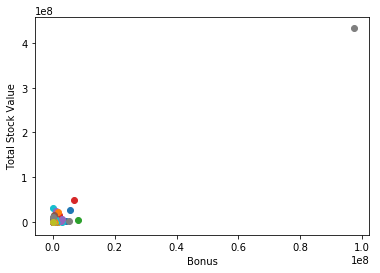

In [2]:
### Task 2: Remove outliers

# We can visualize some of the features we think may be indicators of fraud to get a
# good idea of what the data looks like, potentially identifying some outliers.
# Using the enron61702insiderpay.pdf, we see high dollar values for feature "bonus" and
# "total_stock_value". 
features_outlier_viz = ['bonus', 'total_stock_value']
features = featureFormat(data_dict, features_outlier_viz, sort_keys = True) 

for i in features:
    bonus = i[0]
    total_stock_value = i[1]
    plt.scatter(bonus, total_stock_value)
   

plt.xlabel("Bonus")
plt.ylabel("Total Stock Value")
plt.show()

In [3]:
# In the Outlier Mini-Project we identified "TOTAL" as an important outlier for removal.
# We will include the removal of this "individual" as well as "The Travel Agency in the
# Park" because they are not really individuals working at Enron. We will also remove
# individuals with no data (NaN) for all features, which seemed out of place. These
# outliers are fairly easy to identify and remove. 
for key, value in data_dict.iteritems():
    print key

METTS MARK
BAXTER JOHN C
ELLIOTT STEVEN
CORDES WILLIAM R
HANNON KEVIN P
MORDAUNT KRISTINA M
MEYER ROCKFORD G
MCMAHON JEFFREY
HORTON STANLEY C
PIPER GREGORY F
HUMPHREY GENE E
UMANOFF ADAM S
BLACHMAN JEREMY M
SUNDE MARTIN
GIBBS DANA R
LOWRY CHARLES P
COLWELL WESLEY
MULLER MARK S
JACKSON CHARLENE R
WESTFAHL RICHARD K
WALTERS GARETH W
WALLS JR ROBERT H
KITCHEN LOUISE
CHAN RONNIE
BELFER ROBERT
SHANKMAN JEFFREY A
WODRASKA JOHN
BERGSIEKER RICHARD P
URQUHART JOHN A
BIBI PHILIPPE A
RIEKER PAULA H
WHALEY DAVID A
BECK SALLY W
HAUG DAVID L
ECHOLS JOHN B
MENDELSOHN JOHN
HICKERSON GARY J
CLINE KENNETH W
LEWIS RICHARD
HAYES ROBERT E
MCCARTY DANNY J
KOPPER MICHAEL J
LEFF DANIEL P
LAVORATO JOHN J
BERBERIAN DAVID
DETMERING TIMOTHY J
WAKEHAM JOHN
POWERS WILLIAM
GOLD JOSEPH
BANNANTINE JAMES M
DUNCAN JOHN H
SHAPIRO RICHARD S
SHERRIFF JOHN R
SHELBY REX
LEMAISTRE CHARLES
DEFFNER JOSEPH M
KISHKILL JOSEPH G
WHALLEY LAWRENCE G
MCCONNELL MICHAEL S
PIRO JIM
DELAINEY DAVID W
SULLIVAN-SHAKLOVITZ COLLEEN
WROBEL BRUC

In [4]:
# Now let's remove the obvious outliers affecting our scatterplot.
data_dict.pop('LOCKHART EUGENE E')
data_dict.pop('TOTAL')
data_dict.pop('THE TRAVEL AGENCY IN THE PARK')


# Next in assessing outlier removals we will clean missing values (NaN) in the dataset
# while counting the number of values removed.
clean_data = defaultdict(int)
values = next(data_dict.itervalues()).keys()
for key in data_dict.itervalues():
    for value in values:
        if key[value] == "NaN":
            clean_data[value] += 1
            
print clean_data

defaultdict(<type 'int'>, {'salary': 49, 'to_messages': 57, 'deferral_payments': 105, 'total_payments': 20, 'long_term_incentive': 78, 'loan_advances': 140, 'bonus': 62, 'restricted_stock': 34, 'restricted_stock_deferred': 126, 'total_stock_value': 18, 'shared_receipt_with_poi': 57, 'from_poi_to_this_person': 57, 'exercised_stock_options': 42, 'from_messages': 57, 'other': 52, 'from_this_person_to_poi': 57, 'deferred_income': 95, 'expenses': 49, 'email_address': 32, 'director_fees': 127})


In [5]:
# From the resulting output we see that there has been quite a bit of data removed.
# In reviewing the amount of data removed for the listed features, we will clean off
# the features with the top six highest NaN removal. This should allow for easier and
# efficient training in our machine learning algorithm.

# Features with the top six highest NaN removal: deferral_payments,
# restricted_stock_deferred, deferred_income, loan_advances, director_fees, and
# long_term_incentive

features_clean = ['poi','salary','total_payments','bonus','total_stock_value',
                 'exercised_stock_options','to_messages',
                 'from_poi_to_this_person', 'from_messages',
                 'from_this_person_to_poi','shared_receipt_with_poi'] 


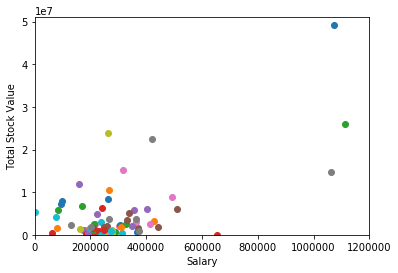

In [6]:
# Now that we have cleaned the data, we will take a look at the features with the least
# amount of NaN removals, "salary" and "total_stock_value". We are replacing "bonus"
# with "salary" (from the scatterplot above) because the data for this feature because
# it has more data points, making it more robust. 
# It may be worth the time to investigate still "bonus" and "total stock value" feature
# pairs considering that the Enron collapse was all about greed and maximizing personal
# gain at the expense of investors. 

features_cleaned = ['salary', 'total_stock_value']
features = featureFormat(data_dict, features_cleaned, remove_any_zeroes=True) 

for i in features:
    salary = i[0]
    total_stock_value = i[1]
    plt.scatter(salary, total_stock_value)

plt.xlabel("Salary")
plt.ylabel("Total Stock Value")
plt.xlim(0, 1200000)
plt.ylim(0, 51000000)
plt.show()

In [7]:
# With the features cleaned, lets train the data to apply regression.  

salary_feature = ['salary']
tsv_feature = ['total_stock_value']

salary_train = featureFormat(data_dict, salary_feature, remove_any_zeroes=True)
tsv_train = featureFormat(data_dict, tsv_feature, remove_any_zeroes=True)

print 'Training Length Salary:', len(salary_train)
print 'Training Length TSV:', len(tsv_train)

Training Length Salary: 94
Training Length TSV: 125


In [8]:
# By printing out the lengths of the salary and tsv training data we find 94 and 125 data points
# respectively. We ran into a ValueError when attempting to set our regression to these values. 
# Limiting the points to the lowest figure (salary: 94) seems to correct this.

salary_train = salary_train[:94]
tsv_train = tsv_train[:94]

from sklearn import linear_model
reg = linear_model.LinearRegression()
reg.fit(salary_train, tsv_train)

pred_tsv = reg.predict(salary_train)

features_cleaned = ['salary', 'total_stock_value']

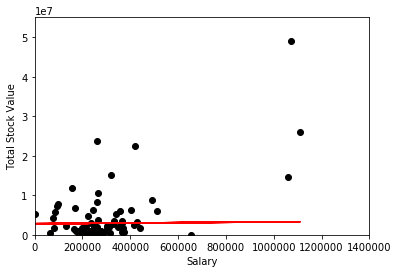

Regression Model Coefficient: [[ 0.4216998]]
Regression Model Intercept: [ 2820872.31776523]
Regression Model Score: 1.0


In [11]:
# We can now plot the linear regression model over top the scatter plot from above 
features_a = featureFormat(data_dict, features_cleaned, remove_any_zeroes=True) 

for i in features_a:
    salary = i[0]
    total_stock_value = i[1]
    plt.scatter(salary, total_stock_value, color = 'black')

plt.xlabel("Salary")
plt.ylabel("Total Stock Value")
plt.xlim(0, 1400000)
plt.ylim(0, 55000000)
plt.plot(salary_train, pred_tsv, color="r")
plt.show()

print 'Regression Model Coefficient:', (reg.coef_)
print 'Regression Model Intercept:', (reg.intercept_)
print 'Regression Model Score:', (reg.score(salary_train, pred_tsv))

# This is a linear regression model of our cleaned data in order to understand how our 
# outlier removals are affecting the data. From the results we notice data points 
# clearly outside our predicted linear regression. Removing these outliers could have 
# a significant impact on revealing interesting information about our POIs.

In [21]:
### list the features you want to look at--first item in the 
### list will be the "target" feature

#features_cleaned = ['salary', 'total_stock_value']
#features1 = featureFormat(data_dict, features_cleaned, remove_any_zeroes=True) 
#target, features = targetFeatureSplit(data)

### training-testing split needed in regression, just like classification
#from sklearn.cross_validation import train_test_split
#feature_train, feature_test, target_train, target_test = train_test_split(features, target, 
#                                                                          test_size=0.5, random_state=42)
#train_color = "b"
#test_color = "r"


### Your regression goes here!
#from sklearn.linear_model import LinearRegression

#reg = LinearRegression()
#reg.fit(feature_train, target_train)

#print "r-squared_score train:", reg.score(feature_train, target_train)     #Regression Score Training Data
#print "r-squared_score test:", reg.score(feature_test, target_test)        #Regression Score: Test Data
#print "slope:", reg.coef_
#print "intercept:", reg.intercept_


### draw the scatterplot, with color-coded training and testing points
#import matplotlib.pyplot as plt
#for feature, target in zip(feature_test, target_test):
#    plt.scatter( feature, target, color=test_color ) 
#for feature, target in zip(feature_train, target_train):
#    plt.scatter( feature, target, color=train_color ) 

### labels for the legend
#plt.scatter(feature_test[0], target_test[0], color=test_color, label="test")
#plt.scatter(feature_test[0], target_test[0], color=train_color, label="train")


### draw the regression line, once it's coded
#try:
#    plt.plot(feature_test, reg.predict(feature_test) )
#except NameError:
#    pass
#plt.xlabel(features_cleaned[1])
#plt.ylabel(features_cleaned[0])
#plt.legend()
#plt.show()

In [12]:
### Task 3: Create new feature(s)
### Store to my_dataset for easy export below.

# Based on reporting of the Enron failures we identify that stock options played
# a significant role in the astronomical incentives to game the system. This is 
# evident because it allowed executives to pick their moment to buy low and sell 
# high, cashing in big on the company's stock. With this is mind it might be 
# prudent to identify when salary and total_stock_value are misaligned. We will
# make sure to include the cleaned stock_salary_ration feature in our feature 
# list in order to see if it should be considered in our feature list.

features_list = ['poi','salary','total_payments','bonus','total_stock_value',
                 'exercised_stock_options','to_messages',
                 'from_poi_to_this_person', 'from_messages',
                 'from_this_person_to_poi','shared_receipt_with_poi'] 

for key, value in data_dict.iteritems():
    if value["salary"]!='NaN' and value["total_stock_value"]!='NaN':
        data_dict[key]["stock_salary_ratio"] = data_dict[key]["total_stock_value"]/data_dict[key]["salary"]
    else: 
        data_dict[key]["stock_salary_ratio"] = 'NaN'

features_list.append("stock_salary_ratio")
print features_list

['poi', 'salary', 'total_payments', 'bonus', 'total_stock_value', 'exercised_stock_options', 'to_messages', 'from_poi_to_this_person', 'from_messages', 'from_this_person_to_poi', 'shared_receipt_with_poi', 'stock_salary_ratio']


In [13]:
# We will use SelectKBest to determine which of our features are best used.
from sklearn.feature_selection import SelectKBest

data = featureFormat(data_dict, features_list)
labels, features = targetFeatureSplit(data)

k_best = SelectKBest(k='all')
k_best.fit(features, labels)
scores = k_best.scores_
pairs = zip(features_list[1:15], scores)

print pairs

[('salary', 18.003739993113935), ('total_payments', 8.671773243105207), ('bonus', 20.524645181851792), ('total_stock_value', 23.898259813869416), ('exercised_stock_options', 24.532722463057976), ('to_messages', 1.5942560277180795), ('from_poi_to_this_person', 5.1422191945069704), ('from_messages', 0.1753832041587958), ('from_this_person_to_poi', 2.3388361146462624), ('shared_receipt_with_poi', 8.4326354230246814), ('stock_salary_ratio', 0.11905356728510776)]


In [14]:
# With the prevention of overfitting in mind let us remove the four features with a 
# KBest value score over 5. Interestingly, despite our initial thoughts on the 
# potential importance of stock_salary_ratio SelectKBest did not identify this 
# feature as required for inclusion in our list. 

features_list.remove("to_messages")
features_list.remove("from_messages")
features_list.remove("from_this_person_to_poi")
features_list.remove("stock_salary_ratio")

print features_list

['poi', 'salary', 'total_payments', 'bonus', 'total_stock_value', 'exercised_stock_options', 'from_poi_to_this_person', 'shared_receipt_with_poi']


In [15]:
# Perhaps unsurprisingly most of the features that were identified for removal
# were related to the emails. 


my_dataset = data_dict

### Extract features and labels from dataset for local testing
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

print 'Labels:', len(labels)
print 'Features:', len(features)


Labels: 142
Features: 142


In [16]:
### Task 4: Try a varity of classifiers
### Please name your classifier clf for easy export below.
### Note that if you want to do PCA or other multi-stage operations,
### you'll need to use Pipelines. For more info:
### http://scikit-learn.org/stable/modules/pipeline.html

# Data split into training and test datasets.
from sklearn.cross_validation import train_test_split
features_train, features_test, labels_train, labels_test = \
    train_test_split(features, labels, test_size=0.5, random_state=42)


# Provided to give you a starting point. Try a variety of classifiers.
# We'll explore a variety of classification algorithms to gauge which
# works best. 

# Naive Bayes supervised classification algorithm and accuracy testing.
# First classifier.
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn import grid_search
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

clf_nb = GaussianNB()
clf_nb.fit(features_train, labels_train)
pred = clf_nb.predict(features_test)
accuracy_nb = accuracy_score(pred, labels_test)

print 'NB Precision:', precision_score(labels_test, pred)
print 'NB Recall:', recall_score(labels_test, pred)
print 'NB Accuracy:', accuracy_nb

NB Precision: 0.555555555556
NB Recall: 0.454545454545
NB Accuracy: 0.859154929577


/Users/craig/anaconda/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [17]:
# Support Vector Machines (SVM) supervised classification algorithm and
# accuracy testing.
# Second classifier.
from sklearn.svm import SVC

clf_svm = SVC()
clf_svm.fit(features_train, labels_train)
pred = clf_svm.predict(features_test)
accuracy_svm = accuracy_score(pred, labels_test)

print 'SVM Precision:', precision_score(labels_test, pred)
print 'SVM Recall:', recall_score(labels_test, pred)
print 'SVM Accuracy:', accuracy_svm

SVM Precision: 0.0
SVM Recall: 0.0
SVM Accuracy: 0.845070422535


/Users/craig/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [18]:
# K-Nearest Neighbors supervised classification algorithm and accuracy
# testing.
# Third classifier.
from sklearn.neighbors import KNeighborsClassifier

clf_knn = KNeighborsClassifier()
clf_knn.fit(features_train, labels_train) 
pred = clf_knn.predict(features_test)
accuracy_knn = accuracy_score(pred, labels_test)

print 'Precision_KNC:', precision_score(labels_test, pred)
print 'Recall_KNC:', recall_score(labels_test, pred)
print 'Accuracy_KNC:', accuracy_knn

Precision_KNC: 0.0
Recall_KNC: 0.0
Accuracy_KNC: 0.845070422535


In [19]:
# Decision Tree supervised classification algorithm and accuracy testing.
# Fourht classifier.
from sklearn import tree

clf_dt = tree.DecisionTreeClassifier()
clf_dt.fit(features_train, labels_train)

pred = clf_dt.predict(features_test)

accuracy_dt = accuracy_score(pred, labels_test)

print 'DT Precision:', precision_score(labels_test, pred)
print 'DT Recall:', recall_score(labels_test, pred)
print 'DT Accuracy:', accuracy_dt

DT Precision: 0.25
DT Recall: 0.181818181818
DT Accuracy: 0.788732394366


In [22]:
### Task 5: Tune your classifier to achieve better than .3 precision and recall 
### using our testing script. Check the tester.py script in the final project
### folder for details on the evaluation method, especially the test_classifier
### function. Because of the small size of the dataset, the script uses
### stratified shuffle split cross validation. For more info: 
### http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.StratifiedShuffleSplit.html

# After struggling to work through various iterations of each of the four classifiers
# above, I decided to search through the UDacity forums for guidance. I eventually 
# found posts related to KNeighbors parameter tuning and GridSearchCV discussions
# that proved helpful. 

from sklearn.neighbors import KNeighborsClassifier

parameters_1 = {'n_neighbors': [1, 2, 4, 6, 8, 10, 12, 14, 16, 18], 
              'weights': ('distance', 'uniform')}
knc = KNeighborsClassifier()
clf_bp = grid_search.GridSearchCV(knc, parameters_1)
clf_bp.fit(features, labels)
clf_bp.best_params_

{'n_neighbors': 6, 'weights': 'uniform'}

In [23]:
from sklearn.neighbors import KNeighborsClassifier

clf_b = KNeighborsClassifier(n_neighbors = 6, weights = 'uniform')
clf_b.fit(features_train, labels_train) 
pred = clf_b.predict(features_test)
accuracy_b = accuracy_score(labels_test, pred)

print accuracy_b

# From the results using GridSearchCV to find the best parameters, we notice that the accuracy
# remains unchanged from the initial classifier, in Task 4. With no impact on accuracy I'm
# looking forward to see the impact on precision and recall. Let's tweak Pipeline in order
# to meet the required guidlines for this project.

0.845070422535


In [25]:
from sklearn import preprocessing

skb = SelectKBest()
scaler = preprocessing.MinMaxScaler()
knc = KNeighborsClassifier()
pipe = Pipeline(steps=[('scaling', scaler), ("SKB", skb), ("KNeighborsClassifier", 
                       knc)])


parameters = {'SKB__k': range(1,7), 'KNeighborsClassifier__n_neighbors': [1, 4, 8, 16, 24, 32, 40, 48, 56, 64], 
              'KNeighborsClassifier__weights': ('distance', 'uniform')}

cv_sss = StratifiedShuffleSplit(labels, 100, random_state=45)
clf_knc = grid_search.GridSearchCV(pipe, parameters, scoring = "f1", cv=cv_sss)
clf_knc.fit(features, labels)
clf = clf_knc.best_estimator_

/Users/craig/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [26]:
# Now we'll test our parameter tweaks using the supplied Tester Script to identify precision
# recall and accuracy of this new KNeighbors classifier. 

from tester import test_classifier

test_classifier(clf, my_dataset, features_list)

Pipeline(steps=[('scaling', MinMaxScaler(copy=True, feature_range=(0, 1))), ('SKB', SelectKBest(k=3, score_func=<function f_classif at 0x11322a6e0>)), ('KNeighborsClassifier', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=4, p=2,
           weights='distance'))])
	Accuracy: 0.86267	Precision: 0.47642	Recall: 0.30300	F1: 0.37042	F2: 0.32679
	Total predictions: 15000	True positives:  606	False positives:  666	False negatives: 1394	True negatives: 12334



In [27]:
### Task 6: Dump your classifier, dataset, and features_list so anyone can
### check your results. You do not need to change anything below, but make sure
### that the version of poi_id.py that you submit can be run on its own and
### generates the necessary .pkl files for validating your results.

dump_classifier_and_data(clf, my_dataset, features_list)